# Setup

Note for this one you have to run it without the anomaly and water column average code, then run the woa regridding file which will allow you to get the anomalies when you run this again.

See this documentation on ragged arrays: 
https://www.nodc.noaa.gov/OC5/WOD/netcdf_descr.html

In [16]:
# import your standard packages
%run ../pkgs.py

# import your local functions
sys.path.insert(1, '../')
from local_functions import *

# make sure the figures plot inline rather than at the end
%matplotlib inline

Default libraries loaded.


# Parameters and Paths

In [17]:
inpath = "/tigress/GEOCLIM/LRGROUP/shared_data/WOD/indian_ocean/concatenated/"
infn = 'all_casts_beginning_to_aug_2020_indian_ocean.nc'
outfn = '../../data/wod18_processed.nc'

lat_bounds = [-1.5, 33]
lon_bounds = [48.5, 102.5]

time_slice = slice('1700-01-01', '2019-12-31')

# Get Data

In [18]:
ds_in = xr.open_dataset(inpath + infn)
ds_in

<xarray.Dataset>
Dimensions:    (cast: 342256, depth: 57)
Coordinates:
  * cast       (cast) int64 0 1 2 3 4 5 ... 342251 342252 342253 342254 342255
  * depth      (depth) int64 0 5 10 15 20 25 ... 1250 1300 1350 1400 1450 1500
Data variables:
    time       (cast) datetime64[ns] ...
    lat        (cast) float32 ...
    lon        (cast) float32 ...
    cast_id    (cast) object ...
    temp       (cast, depth) float64 ...
    sal        (cast, depth) float64 ...
    doxy       (cast, depth) float64 ...
    nitrate    (cast, depth) float64 ...
    phosphate  (cast, depth) float64 ...
Attributes:
    date_created:           03/23/2021
    unmerged_data_url:      https://www.ncei.noaa.gov/access/world-ocean-data...
    geospatial_lat_extent:  decimal degrees north (-2.11,48.733334)
    geospatial_lon_extent:  decimal degrees east (-163.332,102.5)
    help_email:             OCLhelp@noaa.gov
    history:                Merged ../latest/*.nc

# Sort by Time

In [19]:
# round times to nearest day
ds_in["time"] = ds_in.time.dt.floor("D")

# # add time as a coordinate
ds_in = ds_in.assign_coords(unsorted_time=ds_in.time)

# reset profile variables to be with respect to time
ds_in['temp'] = xr.DataArray(ds_in.temp,dims = ['unsorted_time','depth'],coords =[ds_in.time,ds_in.depth])
ds_in['sal'] = xr.DataArray(ds_in.sal,dims = ['unsorted_time','depth'],coords =[ds_in.time,ds_in.depth])
ds_in['doxy'] = xr.DataArray(ds_in.doxy,dims = ['unsorted_time','depth'],coords =[ds_in.time,ds_in.depth])
ds_in['nitrate'] = xr.DataArray(ds_in.nitrate,dims = ['unsorted_time','depth'],coords =[ds_in.time,ds_in.depth])
ds_in['phosphate'] = xr.DataArray(ds_in.phosphate,dims = ['unsorted_time','depth'],coords =[ds_in.time,ds_in.depth])
ds_in['lat'] = xr.DataArray(ds_in.lat,dims = ['unsorted_time'],coords =[ds_in.time])
ds_in['lon'] = xr.DataArray(ds_in.lon,dims = ['unsorted_time'],coords =[ds_in.time])
ds_in['cast_id'] = xr.DataArray(ds_in.cast_id,dims = ['unsorted_time'],coords =[ds_in.time])
# get rid of intial time variable
ds_in = ds_in[['temp','sal','doxy','nitrate','phosphate','lat','lon','cast_id']]

sorted_time = ds_in.unsorted_time.sortby(ds_in.unsorted_time)

# sort based on time
ds_in['temp'] = xr.DataArray(ds_in.temp.sortby(ds_in.unsorted_time),dims = ['time','depth'],coords =[sorted_time,ds_in.depth])
ds_in['sal'] = xr.DataArray(ds_in.sal.sortby(ds_in.unsorted_time),dims = ['time','depth'],coords =[sorted_time,ds_in.depth])
ds_in['doxy'] = xr.DataArray(ds_in.doxy.sortby(ds_in.unsorted_time),dims = ['time','depth'],coords =[sorted_time,ds_in.depth])
ds_in['nitrate'] = xr.DataArray(ds_in.nitrate.sortby(ds_in.unsorted_time),dims = ['time','depth'],coords =[sorted_time,ds_in.depth])
ds_in['phosphate'] = xr.DataArray(ds_in.phosphate.sortby(ds_in.unsorted_time),dims = ['time','depth'],coords =[sorted_time,ds_in.depth])
ds_in['lat'] = xr.DataArray(ds_in.lat.sortby(ds_in.unsorted_time),dims = ['time'],coords =[sorted_time])
ds_in['lon'] = xr.DataArray(ds_in.lon.sortby(ds_in.unsorted_time),dims = ['time'],coords =[sorted_time])
ds_in['cast_id'] = xr.DataArray(ds_in.cast_id.sortby(ds_in.unsorted_time),dims = ['time'],coords =[sorted_time])
ds_in = ds_in[['temp','sal','doxy','nitrate','phosphate','lat','lon','cast_id','time']]
ds_in

<xarray.Dataset>
Dimensions:    (depth: 57, time: 342256)
Coordinates:
  * time       (time) datetime64[ns] 1770-01-01 1770-01-01 ... 2020-07-07
  * depth      (depth) int64 0 5 10 15 20 25 ... 1250 1300 1350 1400 1450 1500
Data variables:
    temp       (time, depth) float64 33.11 nan nan nan nan ... nan nan nan nan
    sal        (time, depth) float64 nan nan nan nan nan ... nan nan nan nan nan
    doxy       (time, depth) float64 nan nan nan nan nan ... nan nan nan nan nan
    nitrate    (time, depth) float64 nan nan nan nan nan ... nan nan nan nan nan
    phosphate  (time, depth) float64 nan nan nan nan nan ... nan nan nan nan nan
    lat        (time) float32 14.366667 14.433333 16.95 ... 12.35 13.299
    lon        (time) float32 99.583336 54.083332 64.35 ... 81.21667 92.1 87.454
    cast_id    (time) object 'OSD_9540691' 'OSD_9540856' ... 'PFL_19992885'
Attributes:
    date_created:           03/23/2021
    unmerged_data_url:      https://www.ncei.noaa.gov/access/world-ocean-dat

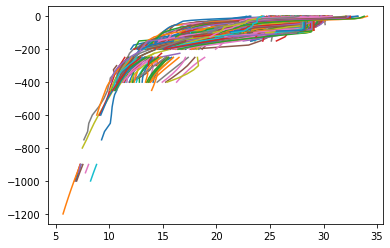

In [20]:
for tt in range(1000):
    plt.plot(ds_in.temp[tt,:],-1*ds_in.depth)

# Linearly interpolate to standard pressure levels

In [21]:
PRES_i = np.array(ds_in.depth)

t = ds_in.time.shape[0]
d = ds_in.depth.shape[0]
for tt in tqdm(range(t), leave = True):
    if tt == 0:
        TEMP_i = np.zeros((t,PRES_i.shape[0]))*np.nan
        DOXY_i = np.zeros((t,PRES_i.shape[0]))*np.nan
        SAL_i = np.zeros((t,PRES_i.shape[0]))*np.nan
        NITRATE_i = np.zeros((t,PRES_i.shape[0]))*np.nan
        PHOSPHATE_i = np.zeros((t,PRES_i.shape[0]))*np.nan


    # conversion [m] -> [dbar]: https://teos-10.github.io/GSW-Python/gsw_flat.html
    pres = gsw.p_from_z(-1*ds_in.depth, [ds_in.lat[tt] for i in range(d)])

    # temp,psal,doxy selection
    temp,sal,doxy = ds_in.temp[tt,:],ds_in.sal[tt,:],ds_in.doxy[tt,:]
    nitrate,phosphate = ds_in.nitrate[tt,:],ds_in.phosphate[tt,:]

    # interpolation
    ft = sp.interp1d(pres,temp,bounds_error=False,fill_value=np.nan)
    TEMP_i[tt,:] = ft(PRES_i)

    fo = sp.interp1d(pres,doxy,bounds_error=False,fill_value=np.nan)
    DOXY_i[tt,:] = fo(PRES_i)

    fs = sp.interp1d(pres,sal,bounds_error=False,fill_value=np.nan)
    SAL_i[tt,:] = fs(PRES_i)

    fn = sp.interp1d(pres,nitrate,bounds_error=False,fill_value=np.nan)
    NITRATE_i[tt,:] = fn(PRES_i)

    fp = sp.interp1d(pres,phosphate,bounds_error=False,fill_value=np.nan)
    PHOSPHATE_i[tt,:] = fp(PRES_i)
            
            
ds_out=xr.Dataset(coords={'time': ds_in.time,
                        'pres': PRES_i})
# add to dataset
ds_out['temp'] = xr.DataArray(TEMP_i,dims = ['time','pres'],coords =[ds_in.time,PRES_i])
ds_out['sal'] = xr.DataArray(SAL_i,dims = ['time','pres'],coords =[ds_in.time,PRES_i])
ds_out['doxy'] = xr.DataArray(DOXY_i,dims = ['time','pres'],coords =[ds_in.time,PRES_i])
ds_out['nitrate'] = xr.DataArray(NITRATE_i,dims = ['time','pres'],coords =[ds_in.time,PRES_i])
ds_out['phosphate'] = xr.DataArray(PHOSPHATE_i,dims = ['time','pres'],coords =[ds_in.time,PRES_i])
ds_out['lat'] = xr.DataArray(ds_in.lat,dims = ['time'],coords =[ds_in.time])
ds_out['lon'] = xr.DataArray(ds_in.lon,dims = ['time'],coords =[ds_in.time])
ds_out['cast_id'] = xr.DataArray(ds_in.cast_id,dims = ['time'],coords =[ds_in.time])
ds_out         

 78%|███████▊  | 267411/342256 [56:01<15:24, 80.93it/s] IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 342256/342256 [1:11:53<00:00, 79.35it/s]


<xarray.Dataset>
Dimensions:    (pres: 57, time: 342256)
Coordinates:
  * time       (time) datetime64[ns] 1770-01-01 1770-01-01 ... 2020-07-07
  * pres       (pres) int64 0 5 10 15 20 25 30 ... 1250 1300 1350 1400 1450 1500
Data variables:
    temp       (time, pres) float64 33.11 nan nan nan nan ... nan nan nan nan
    sal        (time, pres) float64 nan nan nan nan nan ... nan nan nan nan nan
    doxy       (time, pres) float64 nan nan nan nan nan ... nan nan nan nan nan
    nitrate    (time, pres) float64 nan nan nan nan nan ... nan nan nan nan nan
    phosphate  (time, pres) float64 nan nan nan nan nan ... nan nan nan nan nan
    lat        (time) float32 14.366667 14.433333 16.95 ... 12.35 13.299
    lon        (time) float32 99.583336 54.083332 64.35 ... 81.21667 92.1 87.454
    cast_id    (time) object 'OSD_9540691' 'OSD_9540856' ... 'PFL_19992885'

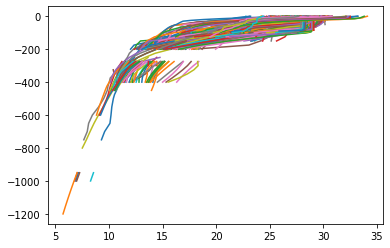

In [22]:
for tt in range(1000):
    plt.plot(ds_out.temp[tt,:],-1*ds_out.pres)

# Subset

In [23]:
ds_out = ds_out.sel(time = time_slice)
ds_out

<xarray.Dataset>
Dimensions:    (pres: 57, time: 337497)
Coordinates:
  * time       (time) datetime64[ns] 1770-01-01 1770-01-01 ... 2019-12-31
  * pres       (pres) int64 0 5 10 15 20 25 30 ... 1250 1300 1350 1400 1450 1500
Data variables:
    temp       (time, pres) float64 33.11 nan nan nan nan ... nan nan nan nan
    sal        (time, pres) float64 nan nan nan nan nan ... nan nan nan nan nan
    doxy       (time, pres) float64 nan nan nan nan nan ... nan nan nan nan nan
    nitrate    (time, pres) float64 nan nan nan nan nan ... nan nan nan nan nan
    phosphate  (time, pres) float64 nan nan nan nan nan ... nan nan nan nan nan
    lat        (time) float32 14.366667 14.433333 16.95 ... 20.110544 19.501572
    lon        (time) float32 99.583336 54.083332 64.35 ... 68.08025 64.72873
    cast_id    (time) object 'OSD_9540691' 'OSD_9540856' ... 'PFL_19770667'

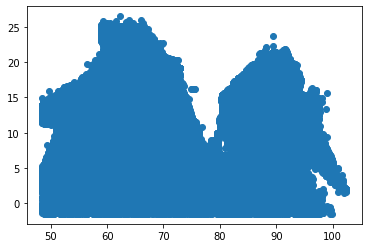

In [24]:
ind = (ds_out.lon < lon_bounds[1]) & (ds_out.lon > lon_bounds[0]) & (ds_out.lat < lat_bounds[1]) & (ds_out.lat > lat_bounds[0])

lat = ds_out.lat[ind]
lon = ds_out.lon[ind]
temp = ds_out.temp[ind,:]
sal = ds_out.sal[ind,:]
doxy = ds_out.doxy[ind,:]
nitrate = ds_out.nitrate[ind,:]
phosphate = ds_out.phosphate[ind,:]
cast_id = ds_out.cast_id[ind]
t = ds_out.time[ind]
pres = ds_out.pres

# take away outside BoB
ind = (lon < 110) & (lon > 99) & (lat < 15) & (lat > 8)

lat = lat[~ind]
lon = lon[~ind]
temp = temp[~ind,:]
sal = sal[~ind,:]
doxy = doxy[~ind,:]
nitrate = nitrate[~ind,:]
phosphate = phosphate[~ind,:]
cast_id = cast_id[~ind]
t = t[~ind]

ind = (lon < 110) & (lon > 100) & (lat < 9) & (lat > 5)

lat = lat[~ind]
lon = lon[~ind]
temp = temp[~ind,:]
sal = sal[~ind,:]
doxy = doxy[~ind,:]
nitrate = nitrate[~ind,:]
phosphate = phosphate[~ind,:]
cast_id = cast_id[~ind]
t = t[~ind]

ind = (lon < 59) & (lon > 45) & (lat < 30) & (lat > 22)

lat = lat[~ind]
lon = lon[~ind]
temp = temp[~ind,:]
sal = sal[~ind,:]
doxy = doxy[~ind,:]
nitrate = nitrate[~ind,:]
phosphate = phosphate[~ind,:]
cast_id = cast_id[~ind]
t = t[~ind]

ind = (lon < 60) & (lon > 45) & (lat < 32) & (lat > 28)

lat = lat[~ind]
lon = lon[~ind]
temp = temp[~ind,:]
sal = sal[~ind,:]
doxy = doxy[~ind,:]
nitrate = nitrate[~ind,:]
phosphate = phosphate[~ind,:]
cast_id = cast_id[~ind]
t = t[~ind]

ind = (lon < 82) & (lon > 70) & (lat < 32) & (lat > 21)

lat = lat[~ind]
lon = lon[~ind]
temp = temp[~ind,:]
sal = sal[~ind,:]
doxy = doxy[~ind,:]
nitrate = nitrate[~ind,:]
phosphate = phosphate[~ind,:]
cast_id = cast_id[~ind]
t = t[~ind]

ind = (lon < 104) & (lon > 94) & (lat < 32) & (lat > 19)

lat = lat[~ind]
lon = lon[~ind]
temp = temp[~ind,:]
sal = sal[~ind,:]
doxy = doxy[~ind,:]
nitrate = nitrate[~ind,:]
phosphate = phosphate[~ind,:]
cast_id = cast_id[~ind]
t = t[~ind]

plt.scatter(lon,lat)

In [25]:
ds_out=xr.Dataset(coords={'time': t,
                        'pres': pres})
# add to dataset
ds_out['temp'] = xr.DataArray(temp,dims = ['time','pres'],coords =[t,pres])
ds_out['sal'] = xr.DataArray(sal,dims = ['time','pres'],coords =[t,pres])
ds_out['doxy'] = xr.DataArray(doxy,dims = ['time','pres'],coords =[t,pres])
ds_out['nitrate'] = xr.DataArray(nitrate,dims = ['time','pres'],coords =[t,pres])
ds_out['phosphate'] = xr.DataArray(phosphate,dims = ['time','pres'],coords =[t,pres])
ds_out['lat'] = xr.DataArray(lat,dims = ['time'],coords =[t])
ds_out['lon'] = xr.DataArray(lon,dims = ['time'],coords =[t])
ds_out 

<xarray.Dataset>
Dimensions:    (pres: 57, time: 310791)
Coordinates:
  * time       (time) datetime64[ns] 1770-01-01 1770-01-01 ... 2019-12-31
  * pres       (pres) int64 0 5 10 15 20 25 30 ... 1250 1300 1350 1400 1450 1500
Data variables:
    temp       (time, pres) float64 28.06 nan nan nan nan ... nan nan nan nan
    sal        (time, pres) float64 nan nan nan nan nan ... nan nan nan nan nan
    doxy       (time, pres) float64 nan nan nan nan nan ... nan nan nan nan nan
    nitrate    (time, pres) float64 nan nan nan nan nan ... nan nan nan nan nan
    phosphate  (time, pres) float64 nan nan nan nan nan ... nan nan nan nan nan
    lat        (time) float32 14.433333 16.95 21.166666 ... 20.110544 19.501572
    lon        (time) float32 54.083332 64.35 90.666664 ... 68.08025 64.72873

# Remove and negative concentration values

Text(0, 0.5, 'min doxy negs removed')

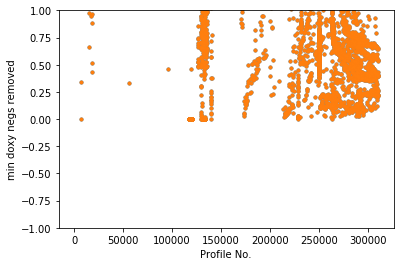

In [26]:
plt.plot(ds_out.doxy.min(dim = 'pres'),'.')
plt.ylim([-1,1])
plt.xlabel('Profile No.')
plt.ylabel('min doxy')

# set negative oxygen values to nan
ds_out['doxy'] = ds_out.doxy.where(ds_out.doxy >= 0)

plt.plot(ds_out.doxy.min(dim = 'pres'),'.')
plt.ylim([-1,1])
plt.xlabel('Profile No.')
plt.ylabel('min doxy negs removed')

# Find Anomalies

In [27]:
# ds_out['temp_anom'] = ds_out.temp - np.array(ds_WOA.temp)
# ds_out['doxy_anom'] = ds_out.doxy - np.array(ds_WOA.doxy)
# ds_out['sal_anom'] = ds_outpsal - np.array(ds_WOA.sal)
# ds_out['nitrate_anom'] = ds_out.nitrate - np.array(ds_WOA.nitrate)
# ds_out['phosphate_anom'] = ds_out.phosphate - np.array(ds_WOA.phosphate)

# Water Column Averages

In [28]:
# find mean temperature and doxy 40-200dbar
ind = (ds_out.pres>= 40) & (ds_out.pres<= 200)

doxy_40_200 = np.nanmean(ds_out.doxy[:,ind],1)
temp_40_200 = np.nanmean(ds_out.temp[:,ind],1)
sal_40_200 = np.nanmean(ds_out.sal[:,ind],1)
nitrate_40_200 = np.nanmean(ds_out.nitrate[:,ind],1)
phosphate_40_200 = np.nanmean(ds_out.phosphate[:,ind],1)
# doxy_anom_40_200 = np.nanmean(ds_out.doxy_anom[:,ind],1)
# temp_anom_40_200 = np.nanmean(ds_out.temp_anom[:,ind],1)
# sal_anom_40_200 = np.nanmean(ds_out.sal_anom[:,ind],1)
# nitrate_anom_40_200 = np.nanmean(ds_out.nitrate_anom[:,ind],1)
# phosphate_anom_40_200 = np.nanmean(ds_out.phosphate_anom[:,ind],1)

# find mean temperature and doxy 50-200dbar
ind = (ds_out.pres>= 50) & (ds_out.pres<= 200)

doxy_50_200 = np.nanmean(ds_out.doxy[:,ind],1)
temp_50_200 = np.nanmean(ds_out.temp[:,ind],1)
sal_50_200 = np.nanmean(ds_out.sal[:,ind],1)
nitrate_50_200 = np.nanmean(ds_out.nitrate[:,ind],1)
phosphate_50_200 = np.nanmean(ds_out.phosphate[:,ind],1)
# doxy_anom_50_200 = np.nanmean(ds_out.doxy_anom[:,ind],1)
# temp_anom_50_200 = np.nanmean(ds_out.temp_anom[:,ind],1)
# sal_anom_50_200 = np.nanmean(ds_out.sal_anom[:,ind],1)
# nitrate_anom_50_200 = np.nanmean(ds_out.nitrate_anom[:,ind],1)
# phosphate_anom_50_200 = np.nanmean(ds_out.phosphate_anom[:,ind],1)

# find mean temperature and doxy 50-225dbar
ind = (ds_out.pres>= 50) & (ds_out.pres<= 225)

doxy_50_225 = np.nanmean(ds_out.doxy[:,ind],1)
temp_50_225 = np.nanmean(ds_out.temp[:,ind],1)
sal_50_225 = np.nanmean(ds_out.sal[:,ind],1)
nitrate_50_225 = np.nanmean(ds_out.nitrate[:,ind],1)
phosphate_50_225 = np.nanmean(ds_out.phosphate[:,ind],1)
# doxy_anom_50_225 = np.nanmean(ds_out.doxy_anom[:,ind],1)
# temp_anom_50_225 = np.nanmean(ds_out.temp_anom[:,ind],1)
# sal_anom_50_225 = np.nanmean(ds_out.sal_anom[:,ind],1)
# nitrate_anom_50_225 = np.nanmean(ds_out.nitrate_anom[:,ind],1)
# phosphate_anom_50_225 = np.nanmean(ds_out.phosphate_anom[:,ind],1)

# add to dataset
ds_out['temp_40_200'] = xr.DataArray(temp_40_200,dims = ['time'],coords =[ds_out.time])
ds_out['doxy_40_200'] = xr.DataArray(doxy_40_200,dims = ['time'],coords =[ds_out.time])
ds_out['sal_40_200'] = xr.DataArray(sal_40_200,dims = ['time'],coords =[ds_out.time])
ds_out['nitrate_40_200'] = xr.DataArray(nitrate_40_200,dims = ['time'],coords =[ds_out.time])
ds_out['phosphate_40_200'] = xr.DataArray(phosphate_40_200,dims = ['time'],coords =[ds_out.time])
# ds_out['temp_anom_40_200'] = xr.DataArray(temp_anom_40_200,dims = ['time'],coords =[ds_out.time])
# ds_out['doxy_anom_40_200'] = xr.DataArray(doxy_anom_40_200,dims = ['time'],coords =[ds_out.time])
# ds_out['sal_anom_40_200'] = xr.DataArray(sal_anom_40_200,dims = ['time'],coords =[ds_out.time])
# ds_out['nitrate_anom_40_200'] = xr.DataArray(nitrate_anom_40_200,dims = ['time'],coords =[ds_out.time])
# ds_out['phosphate_anom_40_200'] = xr.DataArray(phosphate_anom_40_200,dims = ['time'],coords =[ds_out.time])

ds_out['temp_50_200'] = xr.DataArray(temp_50_200,dims = ['time'],coords =[ds_out.time])
ds_out['doxy_50_200'] = xr.DataArray(doxy_50_200,dims = ['time'],coords =[ds_out.time])
ds_out['sal_50_200'] = xr.DataArray(sal_50_200,dims = ['time'],coords =[ds_out.time])
ds_out['nitrate_50_200'] = xr.DataArray(nitrate_50_200,dims = ['time'],coords =[ds_out.time])
ds_out['phosphate_50_200'] = xr.DataArray(phosphate_50_200,dims = ['time'],coords =[ds_out.time])
# ds_out['temp_anom_50_200'] = xr.DataArray(temp_anom_50_200,dims = ['time'],coords =[ds_out.time])
# ds_out['doxy_anom_50_200'] = xr.DataArray(doxy_anom_50_200,dims = ['time'],coords =[ds_out.time])
# ds_out['sal_anom_50_200'] = xr.DataArray(sal_anom_50_200,dims = ['time'],coords =[ds_out.time])
# ds_out['nitrate_anom_50_200'] = xr.DataArray(nitrate_anom_50_200,dims = ['time'],coords =[ds_out.time])
# ds_out['phosphate_anom_50_200'] = xr.DataArray(phosphate_anom_50_200,dims = ['time'],coords =[ds_out.time])

ds_out['temp_50_225'] = xr.DataArray(temp_50_225,dims = ['time'],coords =[ds_out.time])
ds_out['doxy_50_225'] = xr.DataArray(doxy_50_225,dims = ['time'],coords =[ds_out.time])
ds_out['sal_50_225'] = xr.DataArray(sal_50_225,dims = ['time'],coords =[ds_out.time])
ds_out['nitrate_50_225'] = xr.DataArray(nitrate_50_225,dims = ['time'],coords =[ds_out.time])
ds_out['phosphate_50_225'] = xr.DataArray(phosphate_50_225,dims = ['time'],coords =[ds_out.time])
# ds_out['temp_anom_50_225'] = xr.DataArray(temp_anom560_225,dims = ['time'],coords =[ds_out.time])
# ds_out['doxy_anom_50_225'] = xr.DataArray(doxy_anom_50_225,dims = ['time'],coords =[ds_out.time])
# ds_out['sal_anom_50_225'] = xr.DataArray(sal_anom_50_225,dims = ['time'],coords =[ds_out.time])
# ds_out['nitrate_anom_50_225'] = xr.DataArray(nitrate_anom_50_225,dims = ['time'],coords =[ds_out.time])
# ds_out['phosphate_anom_50_225'] = xr.DataArray(phosphate_anom_50_225,dims = ['time'],coords =[ds_out.time])


/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice
  after removing the cwd from sys.path.
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice
  """
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: Mean of empty slice
  
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: Mean of empty slice
  import sys
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice
  
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7

# Find Coastal Mask

In [29]:
xx,yy = np.array(ds_out.lon),np.array(ds_out.lat)

mask = mask_coast(xx,yy,[lon_bounds[0],lon_bounds[1],lat_bounds[0],lat_bounds[1]])
mask.shape
mask_xx = xx[mask]
mask_yy = yy[mask]

ds_out['coastal_mask'] = xr.DataArray(mask,dims = ['coastal_loc'],coords =[np.arange(len(mask))])
ds_out['coastal_mask_xx'] = xr.DataArray(mask_xx,dims = ['coastal_pos'],coords =[np.arange(len(mask[mask]))])
ds_out['coastal_mask_yy'] = xr.DataArray(mask_yy,dims = ['coastal_pos'],coords =[np.arange(len(mask[mask]))])
ds_out['coastal_mask_bounds'] = xr.DataArray([lon_bounds[0],lon_bounds[1],lat_bounds[0],lat_bounds[1]],
                                             dims = ['lonmin,lonmax,latmin,latmax'],
                                             coords =[np.arange(4)])

# Save Data

In [30]:
# delete if already present
if os.path.isfile(outfn):
    os.remove(outfn)

ds_out.to_netcdf(outfn,mode='w',format = "NETCDF4")
ds_out

<xarray.Dataset>
Dimensions:                      (coastal_loc: 310791, coastal_pos: 114356, lonmin,lonmax,latmin,latmax: 4, pres: 57, time: 310791)
Coordinates:
  * time                         (time) datetime64[ns] 1770-01-01 ... 2019-12-31
  * pres                         (pres) int64 0 5 10 15 ... 1350 1400 1450 1500
  * coastal_loc                  (coastal_loc) int64 0 1 2 ... 310789 310790
  * coastal_pos                  (coastal_pos) int64 0 1 2 ... 114354 114355
  * lonmin,lonmax,latmin,latmax  (lonmin,lonmax,latmin,latmax) int64 0 1 2 3
Data variables:
    temp                         (time, pres) float64 28.06 nan nan ... nan nan
    sal                          (time, pres) float64 nan nan nan ... nan nan
    doxy                         (time, pres) float64 nan nan nan ... nan nan
    nitrate                      (time, pres) float64 nan nan nan ... nan nan
    phosphate                    (time, pres) float64 nan nan nan ... nan nan
    lat                          (time